# 0. Introduction to the SU(_N_) formalism with Ba₂FeSi₂O₇

Traditional classical and semiclassical approaches to spin systems start by
placing an SU(2) coherent state on each site. An SU(2) coherent state may
simply be thought of as a dipole, or as a state of a 2-level quantum system,
that is, as a linear combination of combination of $\vert\uparrow\rangle$ and
$\vert\downarrow\rangle$ states.

The idea behind the SU(_N_) generalization of this approach is to instead put
an SU(_N_) coherent state on each site. This is equivalent to having a state
from an _N_-level system on each site, for example, some linear combination of
$\vert\frac{N-1}{2}\rangle$, $\vert\frac{N-2}{2}\rangle$, $\ldots$, $\vert\frac{-(N-1)}{2}\rangle$.
The expectation of any relevant operator (including the dipole operators) can
always be evaluated by taking an expectation value in this coherent state, as
we will demonstrate concretely below.

The chief advantage of this approach is that enables a richer description of
the local physics. In particular, non-magnetic states can be represented
directly and the physics of single-ion anisotropies can be modeled more
faithfully. A useful showcase for this formalism the the square lattice
antiferromagnet Ba₂FeSi₂O₇. This is is a quasi-2D system with effective $S=2$
and strong easy-plane anisotropy. BFSO (as we will refer to it) has been
studied using the SU(_N_) formalism in a number of recent studies, in
particular the following:

- S.-H. Do et al., "Decay and renormalization of a longitudinal mode...," [Nature Communications **12** (2021)](https://doi.org/10.1038/s41467-021-25591-7).
- M. Lee et al., "Field-induced spin level crossings...," [PRB **107** (2023)](https://doi.org/10.1103/PhysRevB.107.144427).
- S.-H. Do et al., "Understanding temperature-dependent SU(3) spin dynamics...," [npj quantum materials **5** (2023)](https://doi.org/10.1038/s41535-022-00526-7).

# 1. Anisotropies and large spins

Before specifying the complete Hamiltonian, we'll consider a cartoon picture
of the single-ion physics. The Hamiltonian for a single $S=2$ spin with single
ion anisotropy is simply $\mathcal{H}_{\mathrm{SI}} = D(\hat{S}^z)^2$, where
$\hat{S}^z$ is in the $S=2$ representation. We can use Sunny to represent this
as a matrix.

In [1]:
# Import relevant libraries
using Sunny, GLMakie, LinearAlgebra, FFTW, Statistics

S = spin_matrices(2)  # Returns a vector of Sx, Sy, Sz
Sx, Sy, Sz = S        # Julia's "unpacking" syntax
# EXERCISE: Write the single-ion anisotropy (with D=1) and call it H_SI
# EXERCISE: How would you add a Zeeman term?

H_SI = Sz^2  # + h*μB*g*Sz

5×5 Hermitian{ComplexF64, Matrix{ComplexF64}}:
 4.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0-0.0im  1.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0-0.0im  0.0-0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0-0.0im  0.0-0.0im  0.0-0.0im  1.0+0.0im  0.0+0.0im
 0.0-0.0im  0.0-0.0im  0.0-0.0im  0.0-0.0im  4.0+0.0im

The result is a diagonal matrix. Ordering of the basis elements is simply
$\vert 2\rangle$, $\vert 1\rangle$, $\vert 0\rangle$, $\vert -1\rangle$, and
$\vert -2\rangle$. Clearly the ground state is the $\vert 0 \rangle$, which
is a non-magnetic state as we can quickly verify. First we'll write a complex
vector to represent the ground state:

In [2]:
Z = [0., 0, 1 + 0im, 0, 0]

5-element Vector{ComplexF64}:
 0.0 + 0.0im
 0.0 + 0.0im
 1.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im

We can now use this to evaluate the expectation values of the dipole operators.

In [3]:
expectation(op, Z) = real(Z' * op * Z)
sx = expectation(Sx, Z)
sy = expectation(Sy, Z)
sz = expectation(Sz, Z)

0.0

This is obviously a non-magnetic state that cannot be represented as a
classical dipole of fixed length $S$. The SU(_N_) formalism provides a way for
modeling states like these and calculating their dynamics. To see this in
action, we'll make a spin system with only this single-ion anisotropy and no
other interactions. We'll start by constructing a primitive tetragonal
lattice.

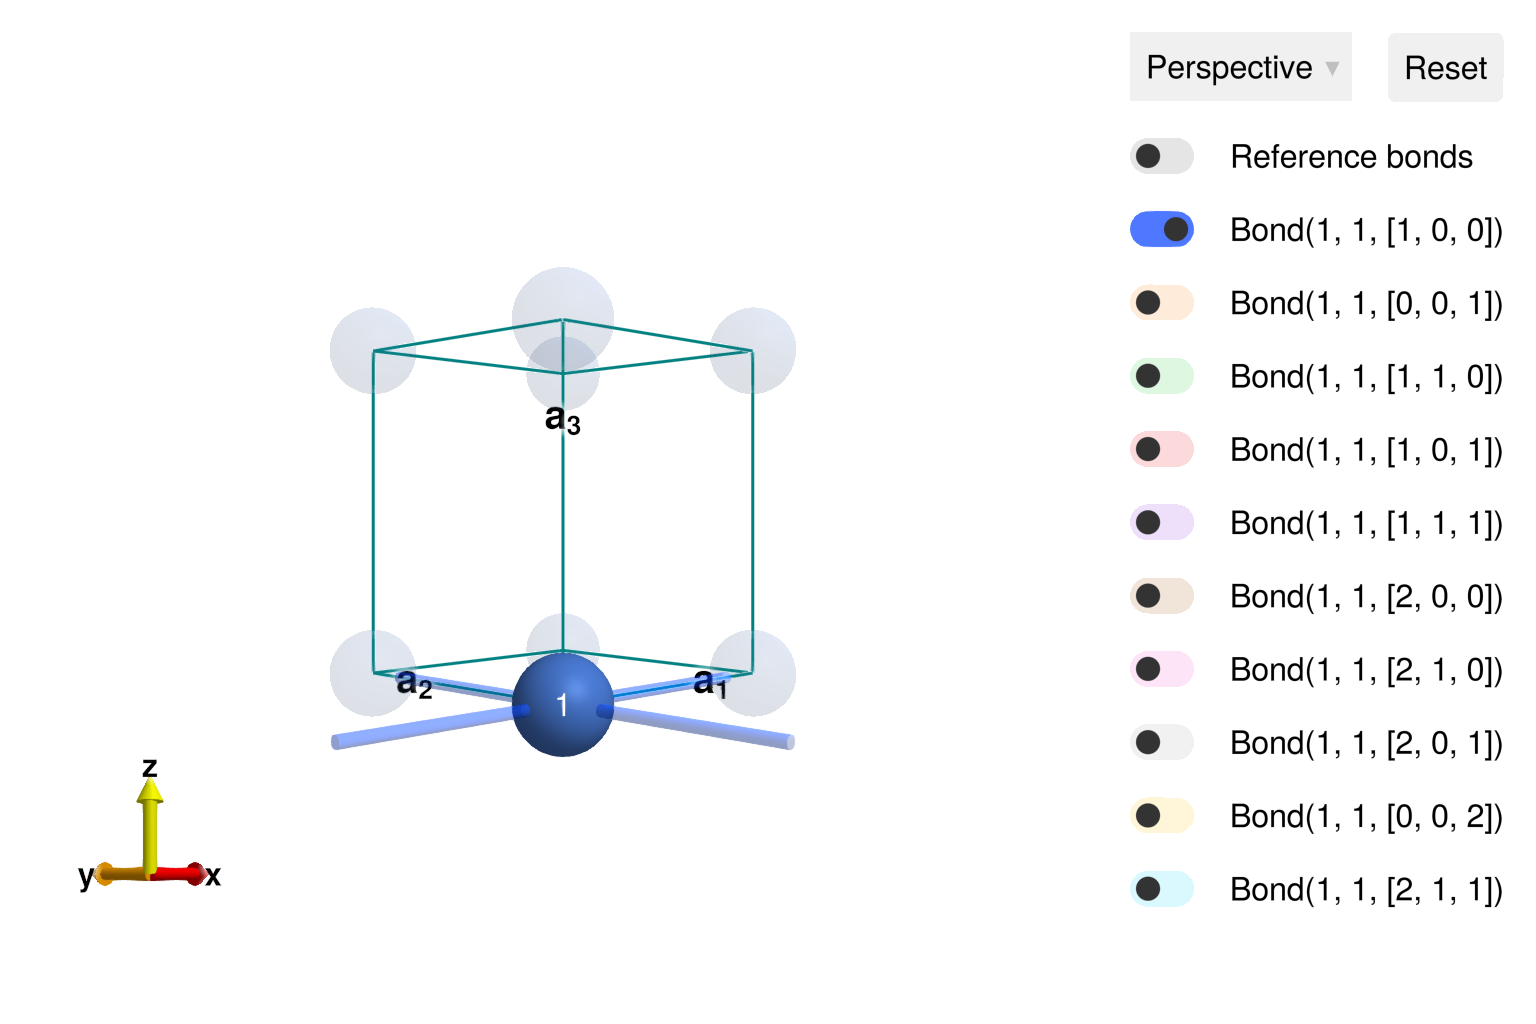

In [4]:
latvecs = lattice_vectors(1, 1, 1.2, 90, 90, 90)
positions = [[0, 0, 0]]
crystal = Crystal(latvecs, positions)
view_crystal(crystal)

Next we'll create a spin system. This is just as in previous examples, only we
will now set the mode to `:SUN`.

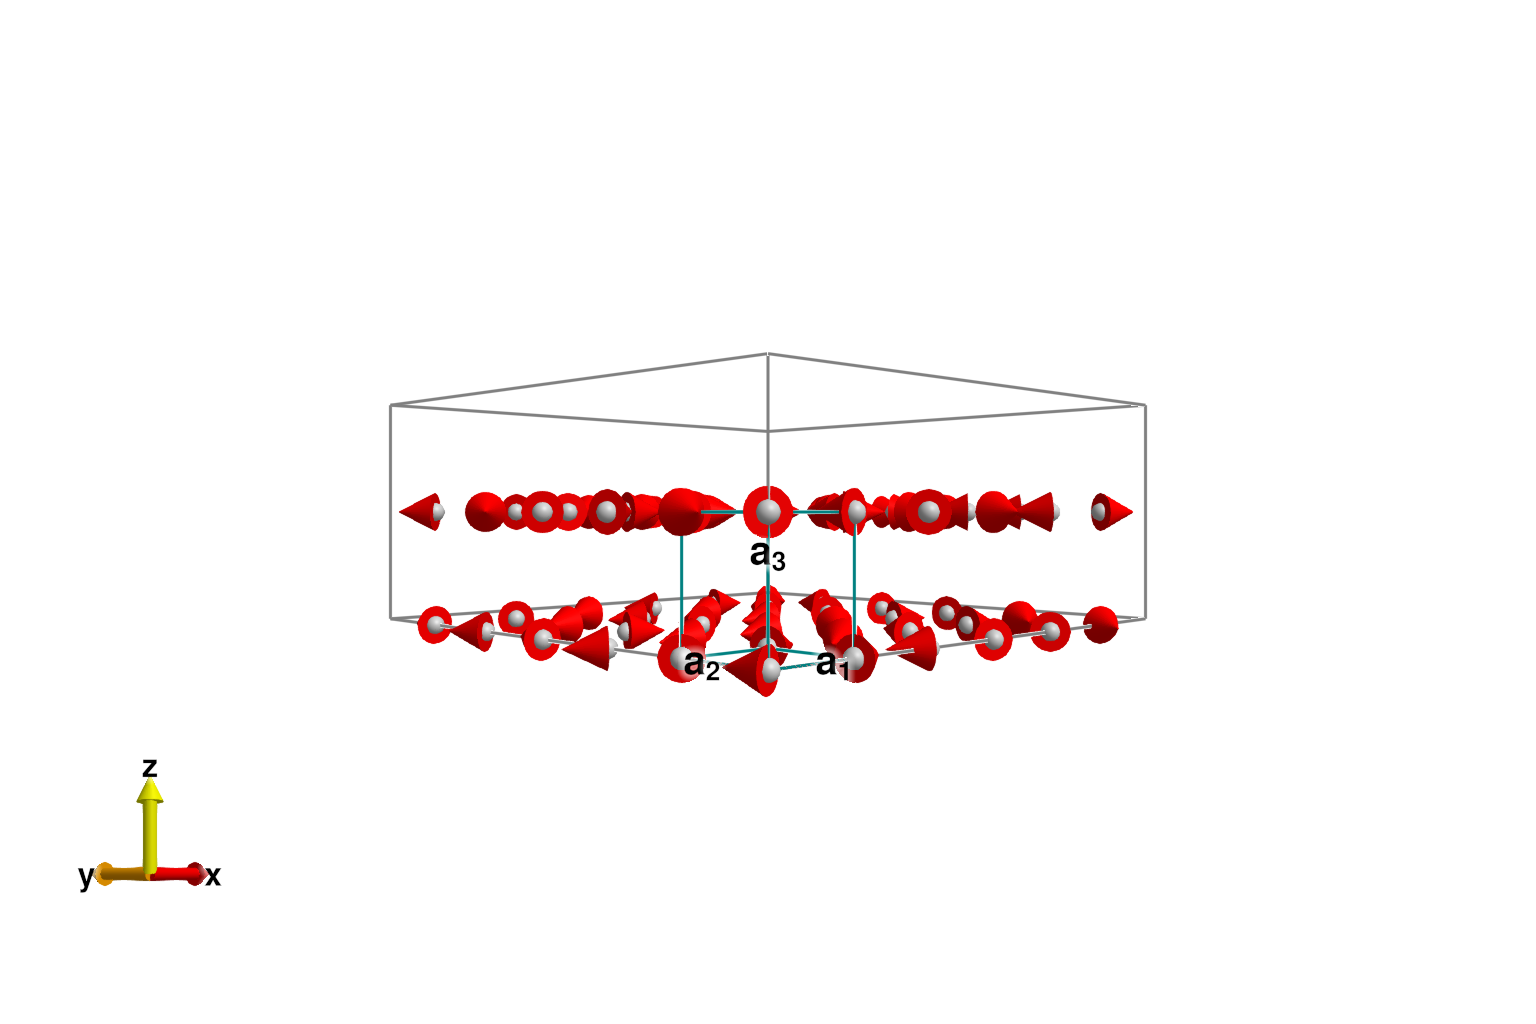

In [5]:
dims = (6, 6, 2)
sys = System(crystal, dims, [SpinInfo(1; S=2, g=2)], :SUN; seed=1)
set_onsite_coupling!(sys, Sz^2, 1) # Set the anisotropy term

randomize_spins!(sys)
minimize_energy!(sys)
plot_spins(sys)

Notice that the dipoles are very short -- but we expect them to be zero. This
is because the tolerances of the `minimize_energy!` function were too loose.
The tolerance can be made tighter by setting the keyword `g_tol` to a very
small value, say, 1e-16.

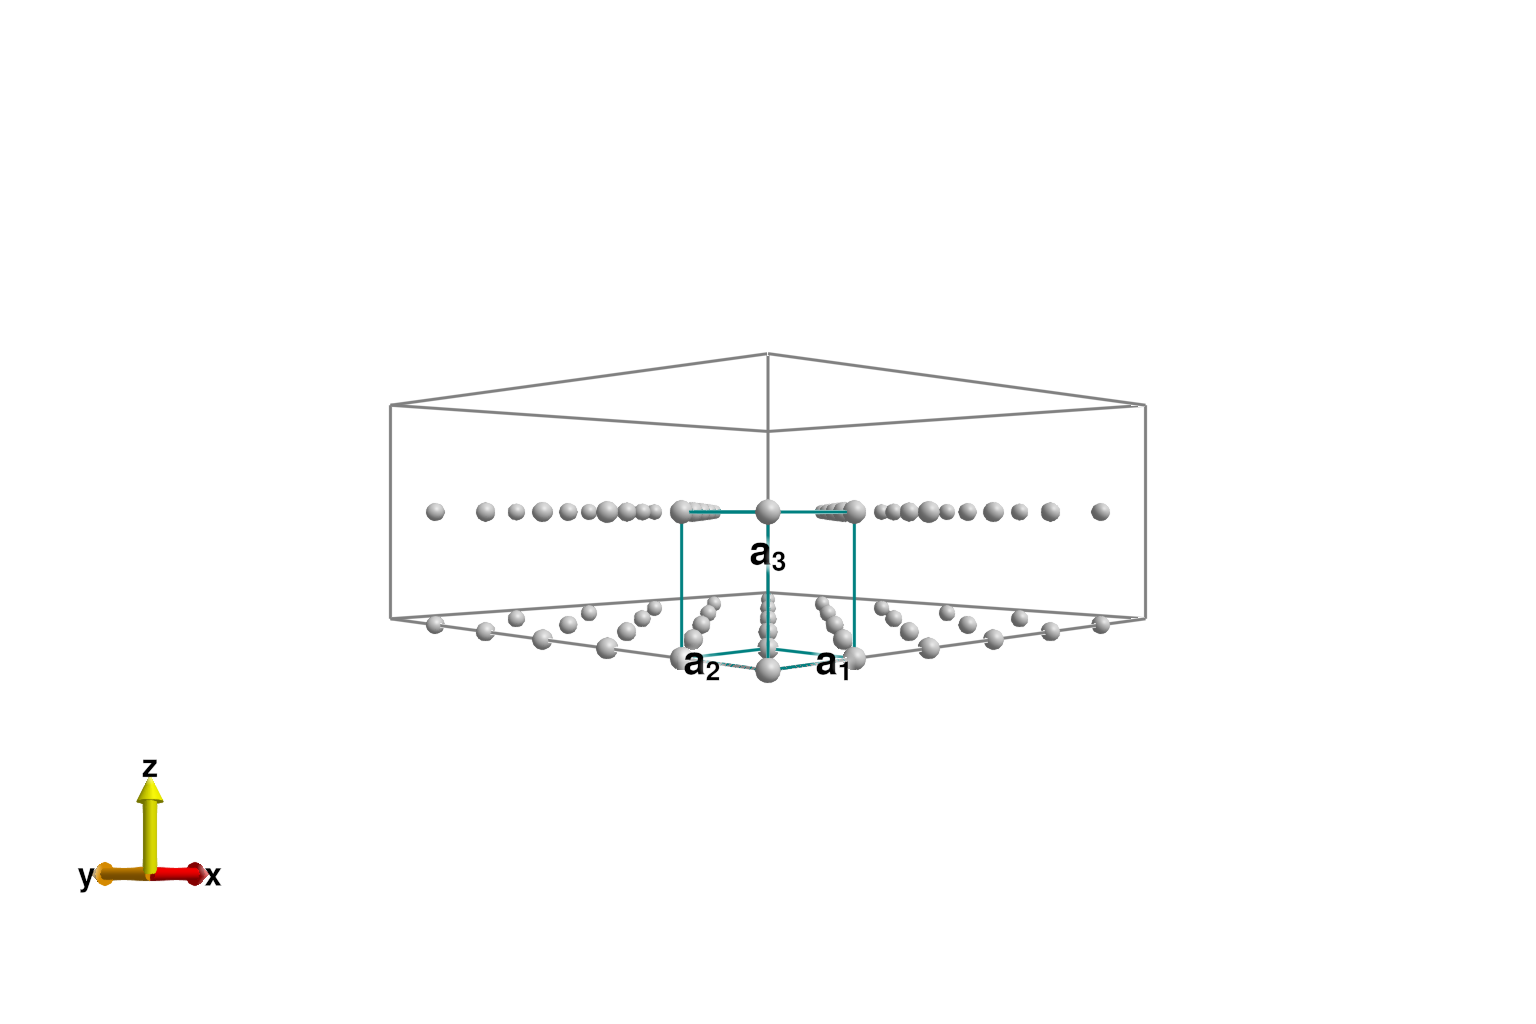

In [6]:
randomize_spins!(sys)
minimize_energy!(sys; g_tol=1e-16)
plot_spins(sys)

Notice now that no dipoles are visible. We can check this more carefully
by examining the state of the spin system. Let's look at the first spin:

In [7]:
sys.dipoles[1,1,1,1]

3-element StaticArraysCore.SVector{3, Float64} with indices SOneTo(3):
 0.0
 0.0
 7.965459555662261e-59

We see that this is close enough to zero for all intents and purposes. We can
also check the coherent state itself to see if it is equal to `Z=(0, 0, 1, 0,
0)` up to overall phase. In SU(_N_) mode, this information is contained in the
`System` field `coherents`:

In [8]:
sys.coherents[1,1,1,1]

# EXERCISE: Construct a primitive _cubic_ lattice and assign the same anisotropy.
# EXERCISE: See what happens when you perform the same procedure in `:dipole` mode.
# EXERCISE: See what happens when you change the sign of `D`.

5-element StaticArraysCore.SVector{5, ComplexF64} with indices SOneTo(5):
                  0.0 + 6.310887241768095e-30im
                  0.0 + 0.0im
 -0.22563453420825122 + 0.9742120184911627im
                  0.0 + 0.0im
                  0.0 + 0.0im

The anisotropy of BFSO is more complicated than the above, but it has a
predominantly easy-plane character -- though, from the exercise above, you may
realize it would be more appropriate to call this a "hard-axis" anisotropy. If
a Zeeman term is added to a hard-axis anisotropy, it induces a number of level
crossings as the field is increased. When exchange interactions are added on
top of this, we will find that the ground state evolves with field as a
mixture of the $\left\vert 0\right\rangle$ and $\left\vert 1\right\rangle$
states, into a mixture of the $\left\vert 0\right\rangle$ and $\left\vert
2\right\rangle$ states, until finally polarizing completely in the $\left\vert
2\right\rangle$ state.

# 2. BFSO Hamiltonian specification

We next turn to specification of the model Hamiltonian for BFSO. We'll start
by defining a lattice for our magnetic Fe ions. This is a tetragonal lattice
as above, but now well use real units. In particular, we'll have `a = b =
8.3194 Å` and `c= 5.336 Å`.

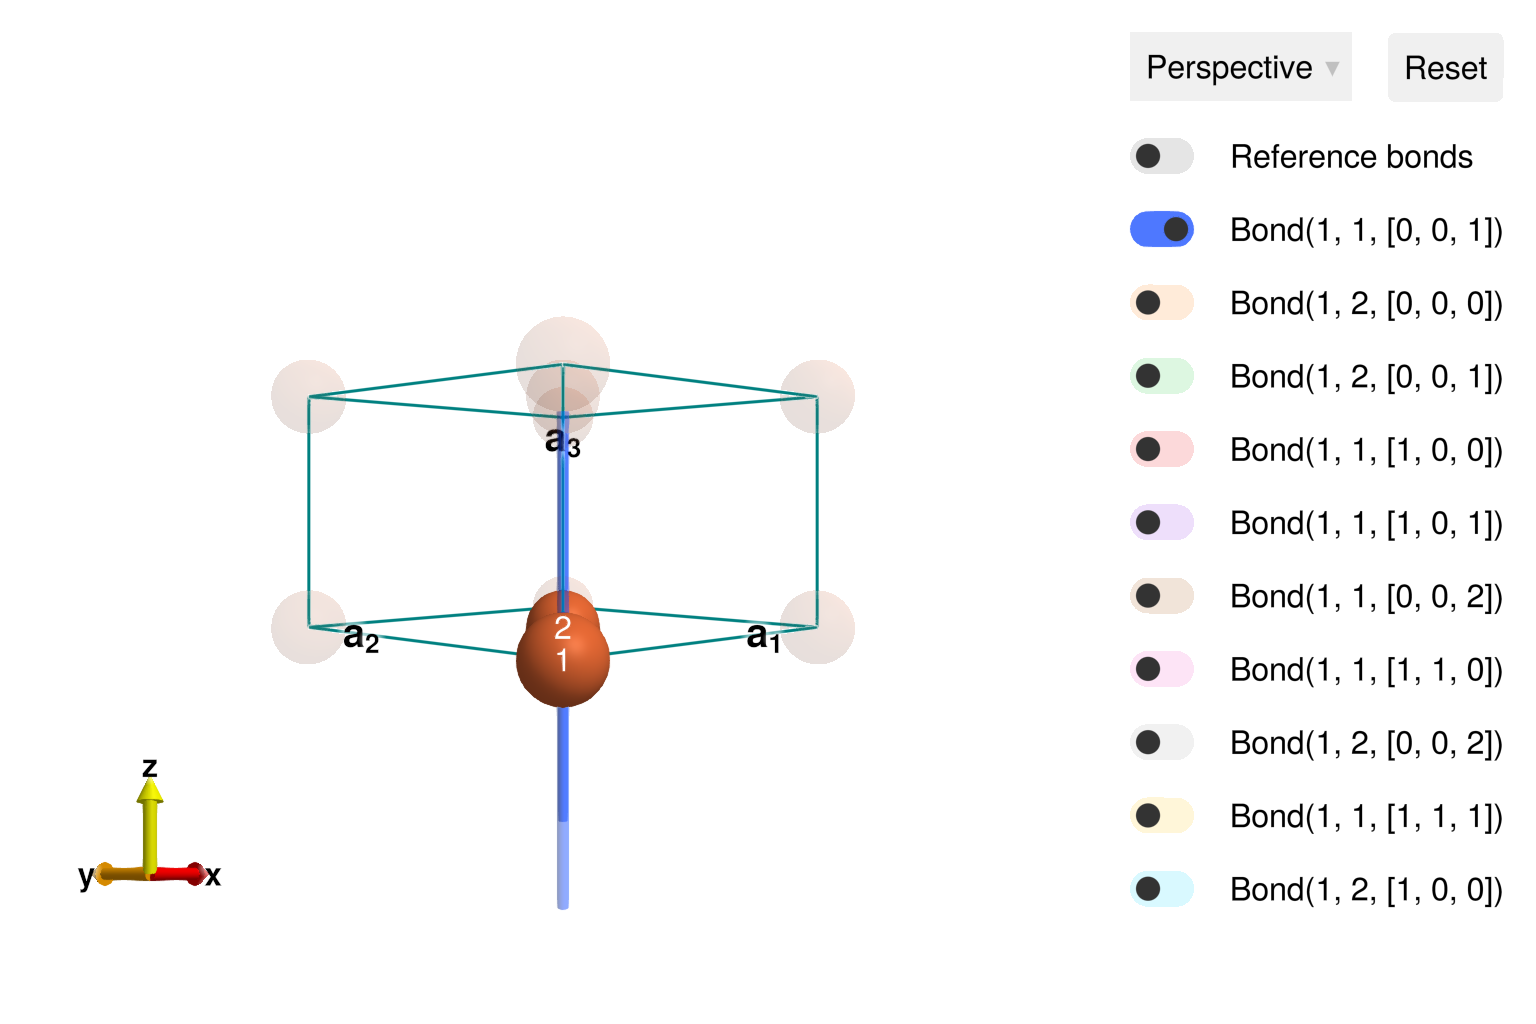

In [9]:
# EXERCISE: Specify this crystal
a = 8.3194
c = 5.336
latvecs = lattice_vectors(a, a, c, 90, 90, 90)
positions = [[0, 0, 0]]
spacegroup = 113    # Want to use the space group for original lattice, of which the Fe ions form a subcrystal
crystal = Crystal(latvecs, positions, spacegroup; types=["Fe"])
view_crystal(crystal)

We use this `Crystal` to specify a `System`.

In [10]:
dims = (6, 6, 2)
sys = System(crystal, dims, [SpinInfo(1; S=2, g=1.93)], :SUN)

System [SU(5)]
Lattice (6×6×2)×2
Energy per site 0


The anisotropy is predominantly hard-axis, as we studied above, but includes a
number of other terms that induce an in-plane XY-ordering as well.

$$
\mathcal{H} = D\left(\hat{S}^z\right)^2 + A\left(\left(\hat{S}^x\right)^4 + \left(\hat{S}^y\right)\right) + C\left(\hat{S}^z\right)^4
$$`

Here $A=1.16 K$, $C=-1.74 K$ and $D=28.65 K$. By default, Sunny using $meV$
and $T$ for units. These values can be converted to $meV$ with the constant `meV_per_K`

In [11]:
# EXERCISE: Express the single ion anisotropy as a matrix and assign it to the `sys`.
A = 1.16 * meV_per_K
C = -1.74 * meV_per_K
D = 28.65 * meV_per_K

Sx, Sy, Sz = spin_matrices(2)
H_SI = D*(Sz)^2 + A*((Sx)^4 + (Sy)^4) + C*(Sz)^4
set_onsite_coupling!(sys, H_SI, 1)

The single-ion Hamiltonian was described as a polynomial in spin operators.
Often times one has access to a description of the crystal-field Hamiltoniann
in terms of Stevens operators. Sunny also provides a function for generating
this matrices, very similar to `spin_matrices`. It returns a 2-dimensional
array, where the first index corresponds to $k$ (irrep label) and the second
to $q$ (row label):

In [12]:
O = stevens_matrices(2)
O[2,-2]
O[2,-1]
O[2,0]
O[2,1]
O[2,2]

5×5 Hermitian{ComplexF64, Matrix{ComplexF64}}:
     0.0+0.0im  0.0+0.0im  2.44949+0.0im  0.0+0.0im      0.0+0.0im
     0.0-0.0im  0.0+0.0im      0.0+0.0im  3.0+0.0im      0.0+0.0im
 2.44949-0.0im  0.0-0.0im      0.0+0.0im  0.0+0.0im  2.44949+0.0im
     0.0-0.0im  3.0-0.0im      0.0-0.0im  0.0+0.0im      0.0+0.0im
     0.0-0.0im  0.0-0.0im  2.44949-0.0im  0.0-0.0im      0.0+0.0im

Note that the indexing for $q$ ranges from $-k$ to $k$. We will not use these
further, but this is a useful resource.

We next turn to defining the exchange interactions. We will define three
antiferromagnetic Heisenberg couplings: nearest-neighbor in-plane,
next-nearest neighbor in-plane, and nearest out-of-plane.

In [13]:
# EXERCISE: Use `view_crystal` to identify bonds representative of the exchange
# interactions just mentioned.
view_crystal(crystal)

bond1 = Bond(1, 2, [0, 0, 0])
bond2 = Bond(1, 1, [1, 0, 0])
bond3 = Bond(1, 1, [0, 0, 1])

J = 1.028 * meV_per_K
J′ = 0.1J
set_exchange!(sys, J, bond1)
set_exchange!(sys, J′, bond2)
set_exchange!(sys, J′, bond3)

We have now completely specified our Hamiltonian. Let's examine the zero-field
ground state.

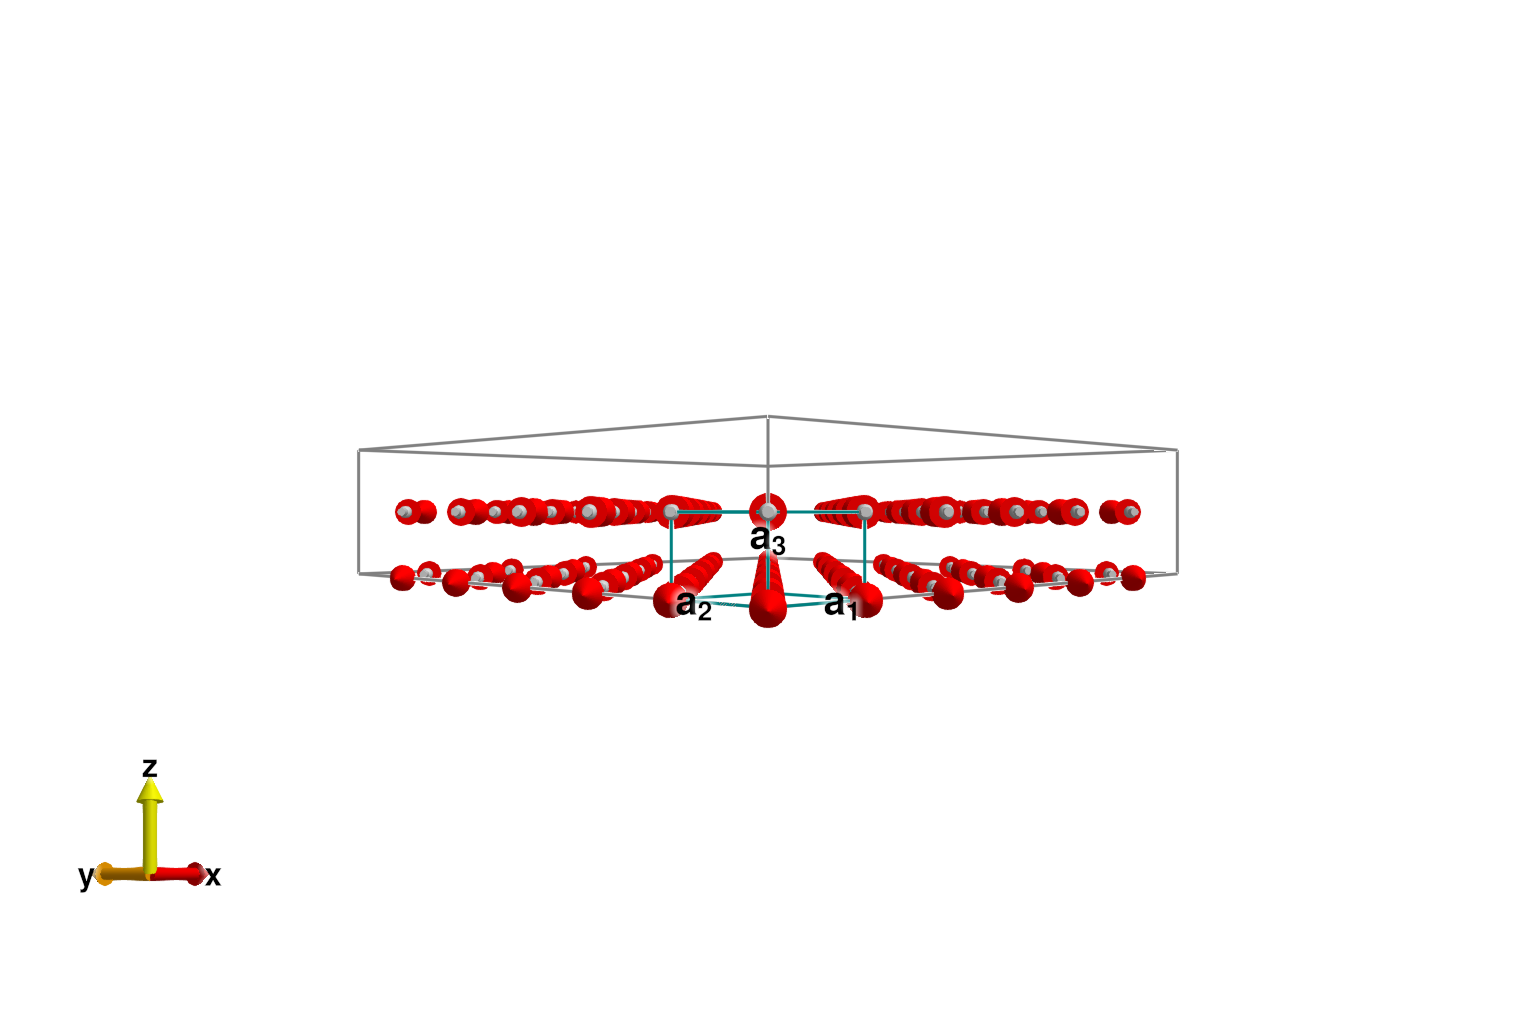

In [14]:
randomize_spins!(sys)
minimize_energy!(sys)
plot_spins(sys)

We clearly see an a staggered XY-ordering in the plane.

In [15]:
# EXERCISE: Examine the `dipoles` and `coherents` fields.
# EXERCISE: using `set_external_field!` to see how the ground state develops with applied field.
# EXERCISE: Write a function that takes dimensions and returns a `System` for BFSO.

function BFSO(dims; mode=:SUN, seed=1)
    a = 8.3194
    c = 5.336
    latvecs = lattice_vectors(a, a, c, 90, 90, 90)
    positions = [[0, 0, 0]]
    spacegroup = 113    # Want to use the space group for original lattice, of which the Fe ions form a subcrystal
    crystal = Crystal(latvecs, positions, spacegroup; types=["Fe"])

    sys = System(crystal, dims, [SpinInfo(1; S=2, g=1.93)], mode; seed)

    A = 1.16 * meV_per_K
    C = -1.74 * meV_per_K
    D = 28.65 * meV_per_K

    Sx, Sy, Sz = spin_matrices(2)
    H_SI = D*(Sz)^2 + A*((Sx)^4 + (Sy)^4) + C*(Sz)^4
    set_onsite_coupling!(sys, H_SI, 1)

    bond1 = Bond(1, 2, [0, 0, 0])
    bond2 = Bond(1, 1, [1, 0, 0])
    bond3 = Bond(1, 1, [0, 0, 1])

    J = 1.028 * meV_per_K
    J′ = 0.1J
    set_exchange!(sys, J, bond1)
    set_exchange!(sys, J′, bond2)
    set_exchange!(sys, J′, bond3)

    return sys
end

BFSO (generic function with 1 method)

# 3. M vs. H
Let's now proceed to generate a figure of $M$ vs $H$ for a range of field
values. First we'll define a function to calculate the magnetization per site.

In [16]:
function magnetization(sys)
    nsites = prod(size(sys.dipoles))
    M_avg = sum(magnetic_moment(sys, site) for site in eachsite(sys)) / nsites / sys.units.μB
    return norm(M_avg)
end

magnetization(sys)

3.410702937401929e-12

We'll also define a function to calculate the relevant order parameter,
which in this case is staggered magnetization in the plane.

In [17]:
function order_parameter(sys)
    xy = [√2/2, √2/2, 0]  # Unit vector in the (1, 1, 0) direction
    M_xy = 0.0
    for site in eachsite(sys)
        sublattice = (-1)^(site.I[4]) * (-1)^(site.I[3])
        M_xy = sublattice * (magnetic_moment(sys, site) ⋅ xy) / sys.units.μB
    end
    return abs(M_xy)
end

order_parameter(sys)

2.12342456792519

Then we'll simply generate a list of applied field values and iteratively
apply those fields, reoptimizing the spin configuration each time.

In [18]:
Hs = range(0.0, 55.0, 50)
Ms = Float64[]
OPs = Float64[]
for H in Hs
    set_external_field!(sys, (0, 0, H))
    minimize_energy!(sys)
    push!(Ms, magnetization(sys))
    push!(OPs, order_parameter(sys))
end

fig = Figure(size=(1200,400))
scatter(fig[1,1], Hs, Ms; axis=(xlabel="H", ylabel="M"))
scatter(fig[1,2], Hs, OPs; axis=(xlabel="H", ylabel="Staggered XY Magnetization"))

Makie.AxisPlot(Axis (1 plots), Scatter{Tuple{Vector{Point{2, Float32}}}})

# 4. Temperature-dependent bulk characteristics

We'll next consider some bulk measurements that depend on temperature. There
is essentially no change in behavior relative to `:dipole` mode. The same
basic functions, e.g. `Langevin`, `suggest_timestep`, `step!`, work without
modification. However, in the background Sunny will be using SU(_N_) coherent
states and the Langevin dynamics will be performed using the SU(_N_)
generalization of the Landau-Lifshitz-Gilbert equations.

We'll first collect information at a range of temperatures: energy, the order
parameter, and magnetization along the z-axis. After this initial round of
data collection, we'll apply a small field in the z-direction. We'll then be
able to make simple estimates of the heat capacity and susceptibility.

Before setting up the main iteration, we'll give some idea of the sorts of
test you should perform to determine things like step size, thermalization
time, decorrelation time, and related matters.

Let's start by considering step size and thermalization time

Consider dt ≈ 0.04579 for this spin configuration at tol = 0.01.
Consider dt ≈ 0.04579 for this spin configuration at tol = 0.01.
Consider dt ≈ 0.04576 for this spin configuration at tol = 0.01.


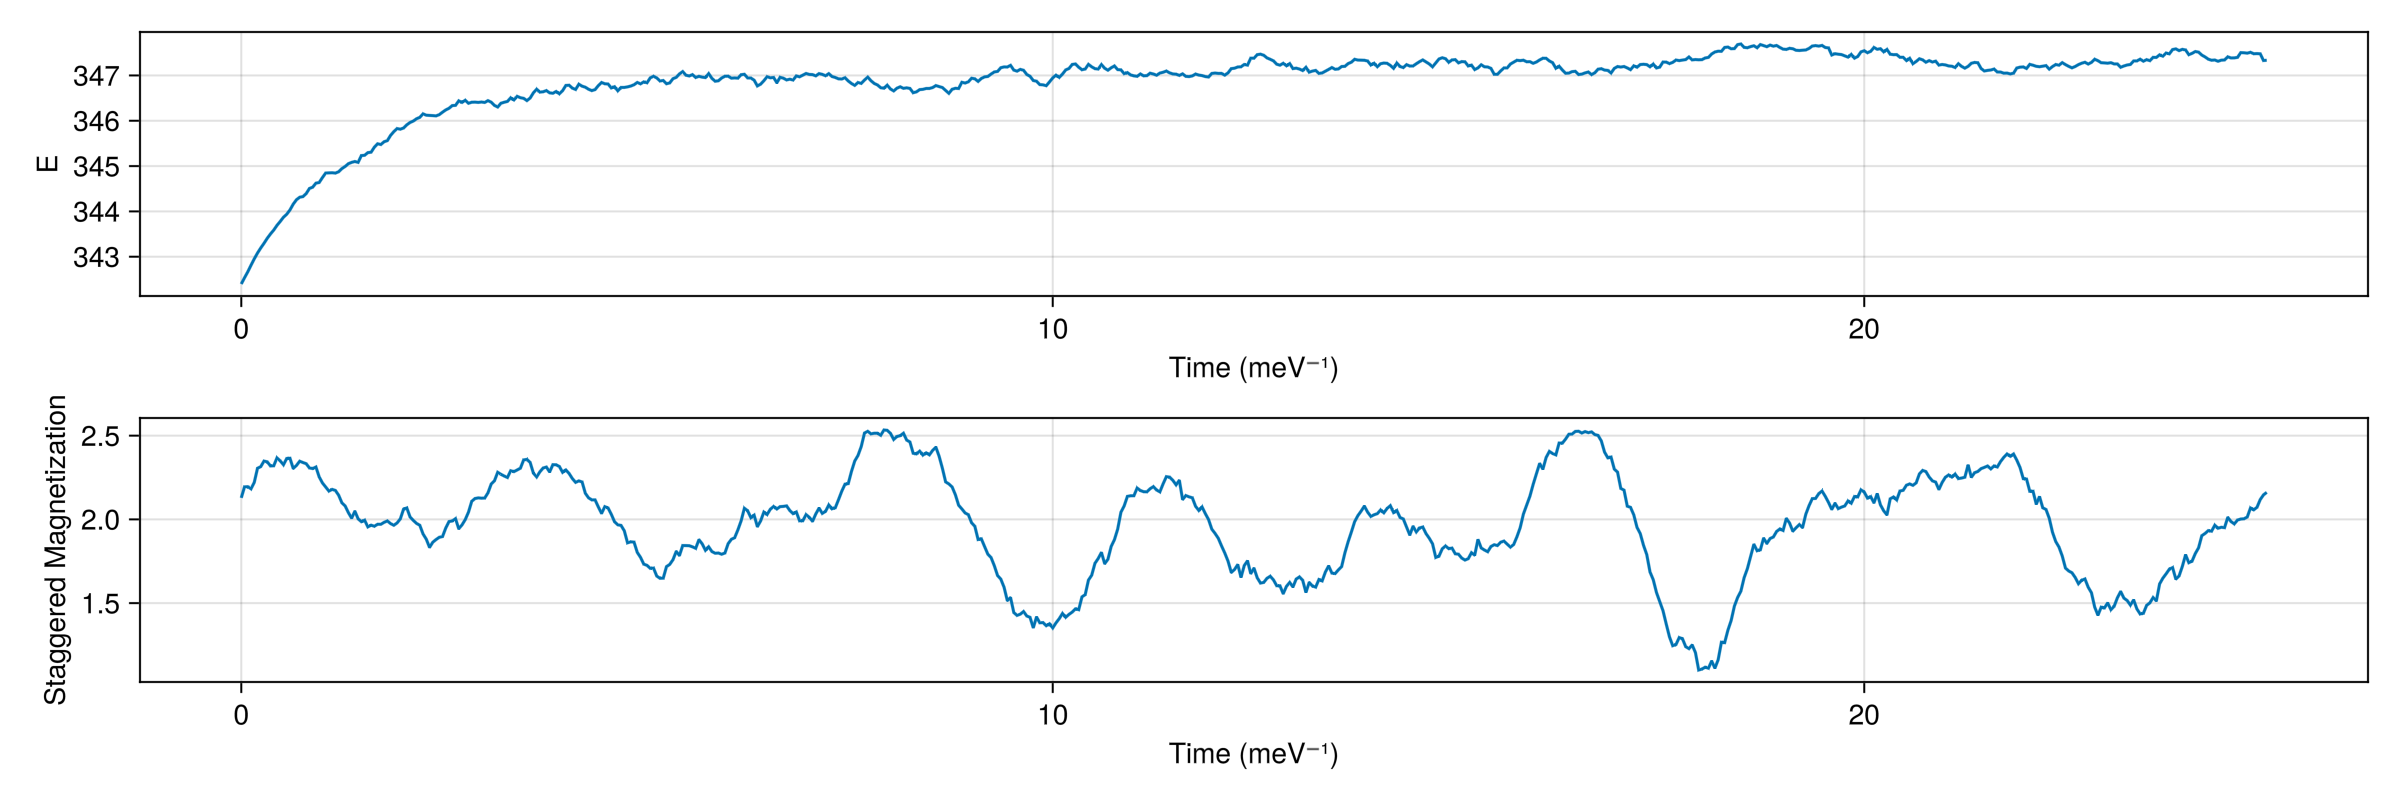

In [19]:
sys = BFSO((6, 6, 2))
randomize_spins!(sys)
minimize_energy!(sys)

integrator = Langevin(; kT=0.1*meV_per_K, damping=0.1)
suggest_timestep(sys, integrator; tol=1e-2)
integrator.kT = 1.0*meV_per_K
suggest_timestep(sys, integrator; tol=1e-2)
integrator.kT = 10.0*meV_per_K
suggest_timestep(sys, integrator; tol=1e-2)

integrator.dt = dt = 0.04
integrator.kT = kT = 0.1 * meV_per_K
minimize_energy!(sys)

dur = 25.0
nsteps = round(Int, dur/dt)
OPs = zeros(nsteps)
Es = zeros(nsteps)
for i in 1:nsteps
    step!(sys, integrator)
    OPs[i] = order_parameter(sys)
    Es[i] = energy(sys)
end

ts = collect(0:nsteps-1) .* dt
fig = Figure(size=(1200,400))
lines(fig[1,1], ts, Es; axis=(ylabel="E", xlabel = "Time (meV⁻¹)"))
lines(fig[2,1], ts, OPs; axis=(ylabel="Staggered Magnetization", xlabel="Time (meV⁻¹)"))
fig

By informal inspection, we can see that the system has thermalized pretty well
after a duration of 10 meV⁻¹ at low temperature, so this will certainly be
enough for higher temperatures as well. This corresponds to 250 steps. The
decorrelation time -- the time needed to run the Langevin dynamics between
collecting samples -- can be estimated by looking at a time series after
thermalization

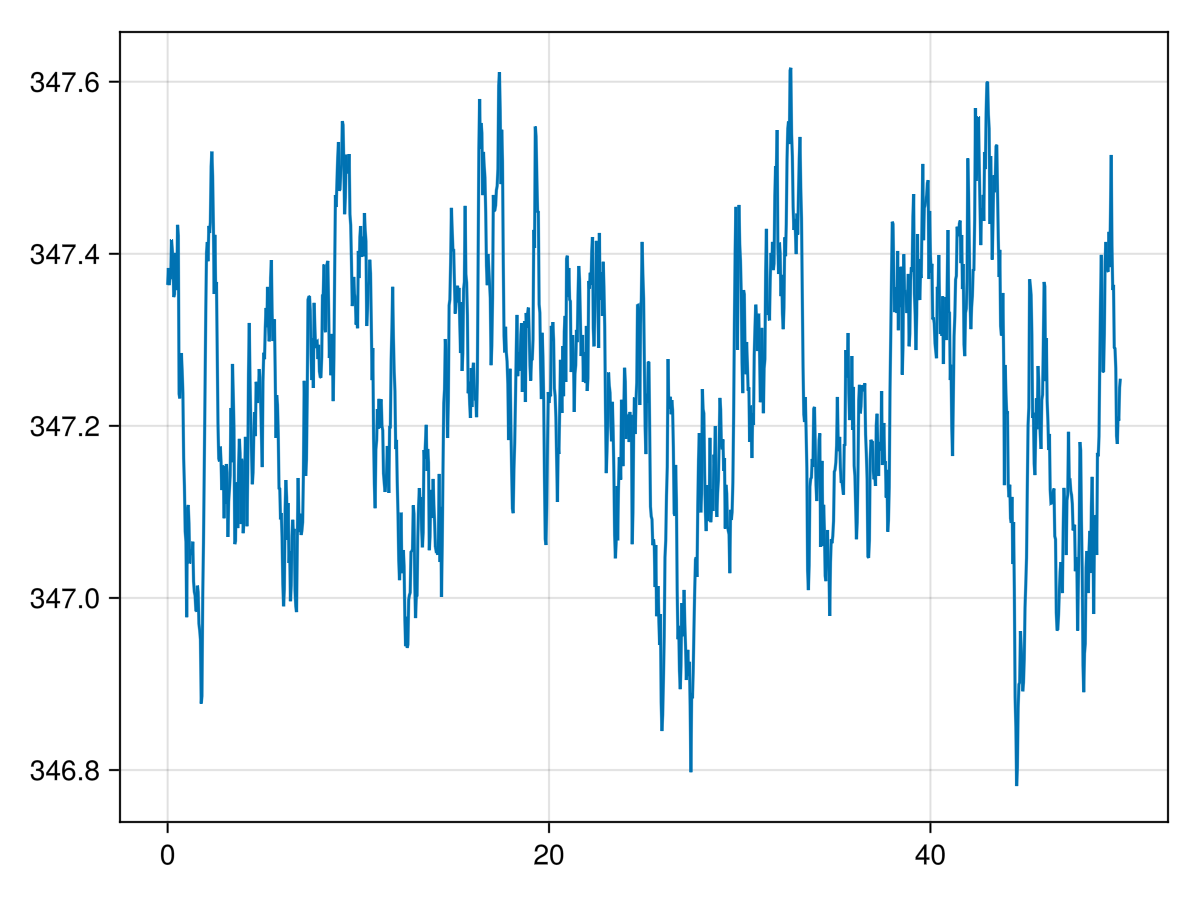

In [20]:
dur = 50.0
nsteps = round(Int, dur/dt)
signal = zeros(nsteps)
for i in 1:nsteps
    step!(sys, integrator)
    signal[i] = energy(sys)
end

ts = collect(0:nsteps-1) .* dt
lines(ts, signal)

We'll next write a quick function to calculate the autocorrelation of this signal.
We can use this information to estimate the decorrelation time of the signal.

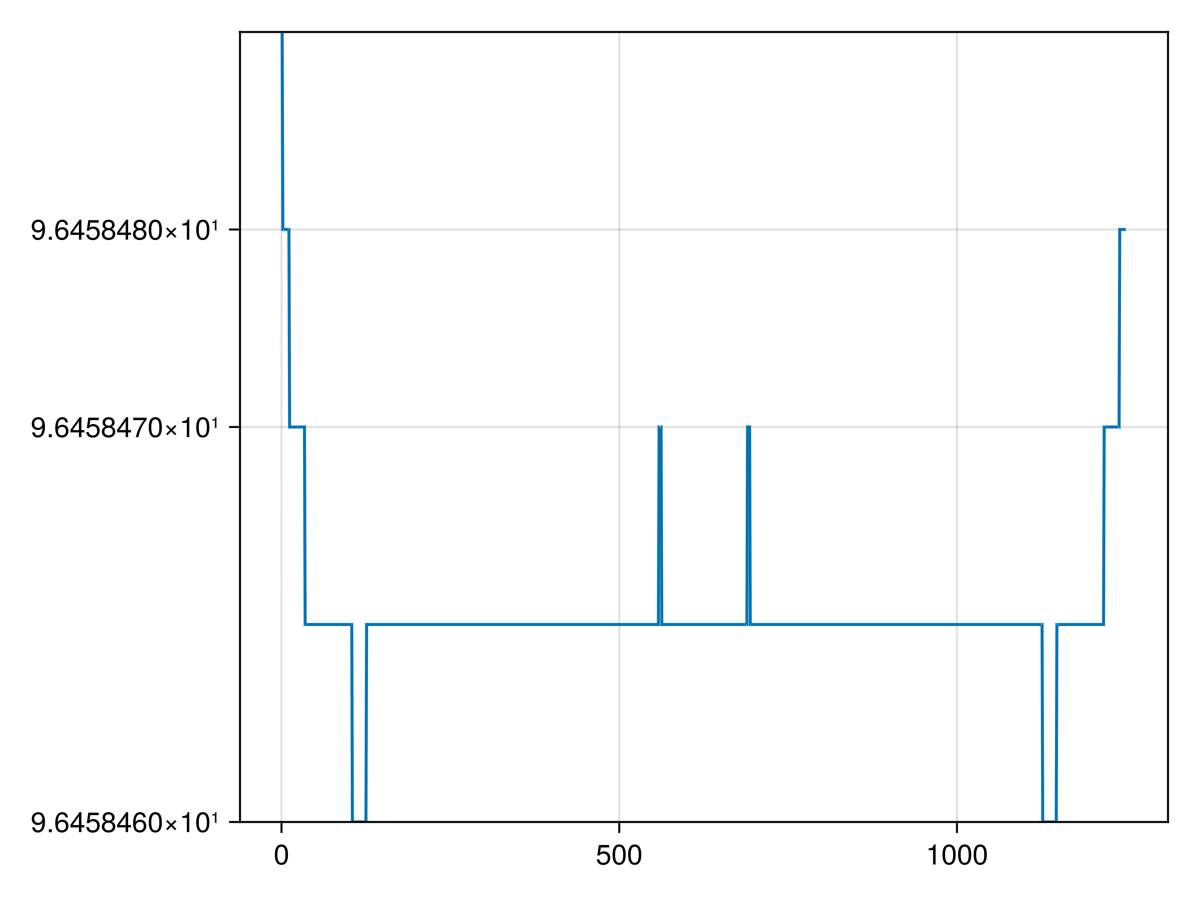

In [21]:
function ac(sig)
    ts_ft = fft(sig)                  # Calculate the Fourier transform of the signal
    ts_power = conj.(ts_ft) .* ts_ft  # Calculate the power spectrum
    return real.(ifft(ts_power))      # Inverse Fourier transform the power spectrum
end

lines(ac(signal) ./ nsteps^2)

# EXERCISE: Redo the above using the order parameter instead.

To do this analysis properly, this process should be repeated for many
different time-series and averaged. Moreover, the analysis should be performed
for each temperature of interest. For the sake of expediency, we'll simply
select a decorrelation interval of 125 steps, which looks to be a typical peak
"width" at low temperatures, and use it for the remainder of the study.

We'll next select a range of temperatures and collect samples of different
properties at each temperature, specifically energy, the order parameter, and
magnetization along the z-axis.

In [22]:
sys = BFSO((10, 10, 2); )
randomize_spins!(sys)
minimize_energy!(sys)
plot_spins(sys)

# Select a temperature range
nkTs = 25
kTs = 10 .^ collect(range(log10(0.1), log10(2.5), nkTs))  # In Kelvin
kTs *= meV_per_K         # Convert to meV

# Reset the system in the zero-field ground state
set_external_field!(sys, (0, 0, 0))
minimize_energy!(sys)

# Collect statistics
nsamples = 100

Es_μ = zeros(nkTs)
Es_σ = zeros(nkTs)
OPs_μ = zeros(nkTs)

@time for (i, kT) in enumerate(kTs)
    integrator.kT = kT

    # Thermalize the system at the new temperature
    for _ in 1:250
        step!(sys, integrator)
    end

    Es = zeros(nsamples)
    OPs = zeros(nsamples)
    Ms = zeros(nsamples)

    # Collect samples
    @time for n in 1:nsamples

        # Decorrelate the system
        for _ in 1:125
            step!(sys, integrator)
        end

        # Collect samples
        Es[n] = energy_per_site(sys)
        OPs[n] = order_parameter(sys)
    end

    Es_μ[i] = mean(Es)
    Es_σ[i] = std(Es)
    OPs_μ[i] = mean(OPs)
end

# Estimate heat capacity with finite differences
ΔE = Es_μ[2:end] - Es_μ[1:end-1]
ΔT = kTs[2:end] - kTs[1:end-1]
kTs_mid = (kTs[1:end-1] + kTs[2:end]) / 2

# Plot the results
fig = Figure()
scatter(fig[1,1], kTs / meV_per_K, Es_μ; axis=(xscale=log10, ylabel="Energy (meV)", xlabel="T (K)"))
# scatter(fig[1,2], kTs_mid / meV_per_K, ΔE ./ ΔT; axis=(xscale=log10, ylabel="dE/dT", xlabel="T (K)"))
# scatter(fig[1,3], kTs / meV_per_K, OPs_μ; axis=(xscale=log10, ylabel="OP", xlabel="T (K)"))
# EXERCISE: Collect statistics for a long time, uncomment the above, and examine the results.

  1.658728 seconds (401 allocations: 14.094 KiB)
  1.660207 seconds (401 allocations: 14.094 KiB)
  1.659104 seconds (401 allocations: 14.094 KiB)
  1.658994 seconds (401 allocations: 14.094 KiB)
  1.661581 seconds (401 allocations: 14.094 KiB)
  1.662695 seconds (401 allocations: 14.094 KiB)
  1.660685 seconds (401 allocations: 14.094 KiB)
  1.659373 seconds (401 allocations: 14.094 KiB)
  1.658961 seconds (401 allocations: 14.094 KiB)
  1.659822 seconds (401 allocations: 14.094 KiB)
  1.669693 seconds (401 allocations: 14.094 KiB)
  1.658703 seconds (401 allocations: 14.094 KiB)
  1.658896 seconds (401 allocations: 14.094 KiB)
  1.658313 seconds (401 allocations: 14.094 KiB)
  1.659403 seconds (401 allocations: 14.094 KiB)
  1.659957 seconds (401 allocations: 14.094 KiB)
  1.659091 seconds (401 allocations: 14.094 KiB)
  1.659839 seconds (401 allocations: 14.094 KiB)
  1.658833 seconds (401 allocations: 14.094 KiB)
  1.659906 seconds (401 allocations: 14.094 KiB)
  1.661319 seconds (

Makie.AxisPlot(Axis (1 plots), Scatter{Tuple{Vector{Point{2, Float32}}}})

# 5. Spin waves

A conceptually useful way to think of linear spin wave theory is as the
quantization of classical dynamics linearized about the ground state. An
important point is that for an S=1/2 spin, it is not possible to have
longitudinal oscillations classically -- the classical magnitude has a fixed
value of S. Similarly, at the linear level, there are no longitudinal
oscillations in a traditional SWT calculation -- one has to incorporate 1/S
corrections to recover such behavior. In the SU(_N_) generalization, the
"spin" has additional degrees of freedom, corresponding to, for example,
higher-order moments like quadrupoles and octupoles. As a consequence, it does
the dipole does not have a fixed magnitude. We can illustrate this aspect of
the SU(_N_) classical dynamics with a simple animation.

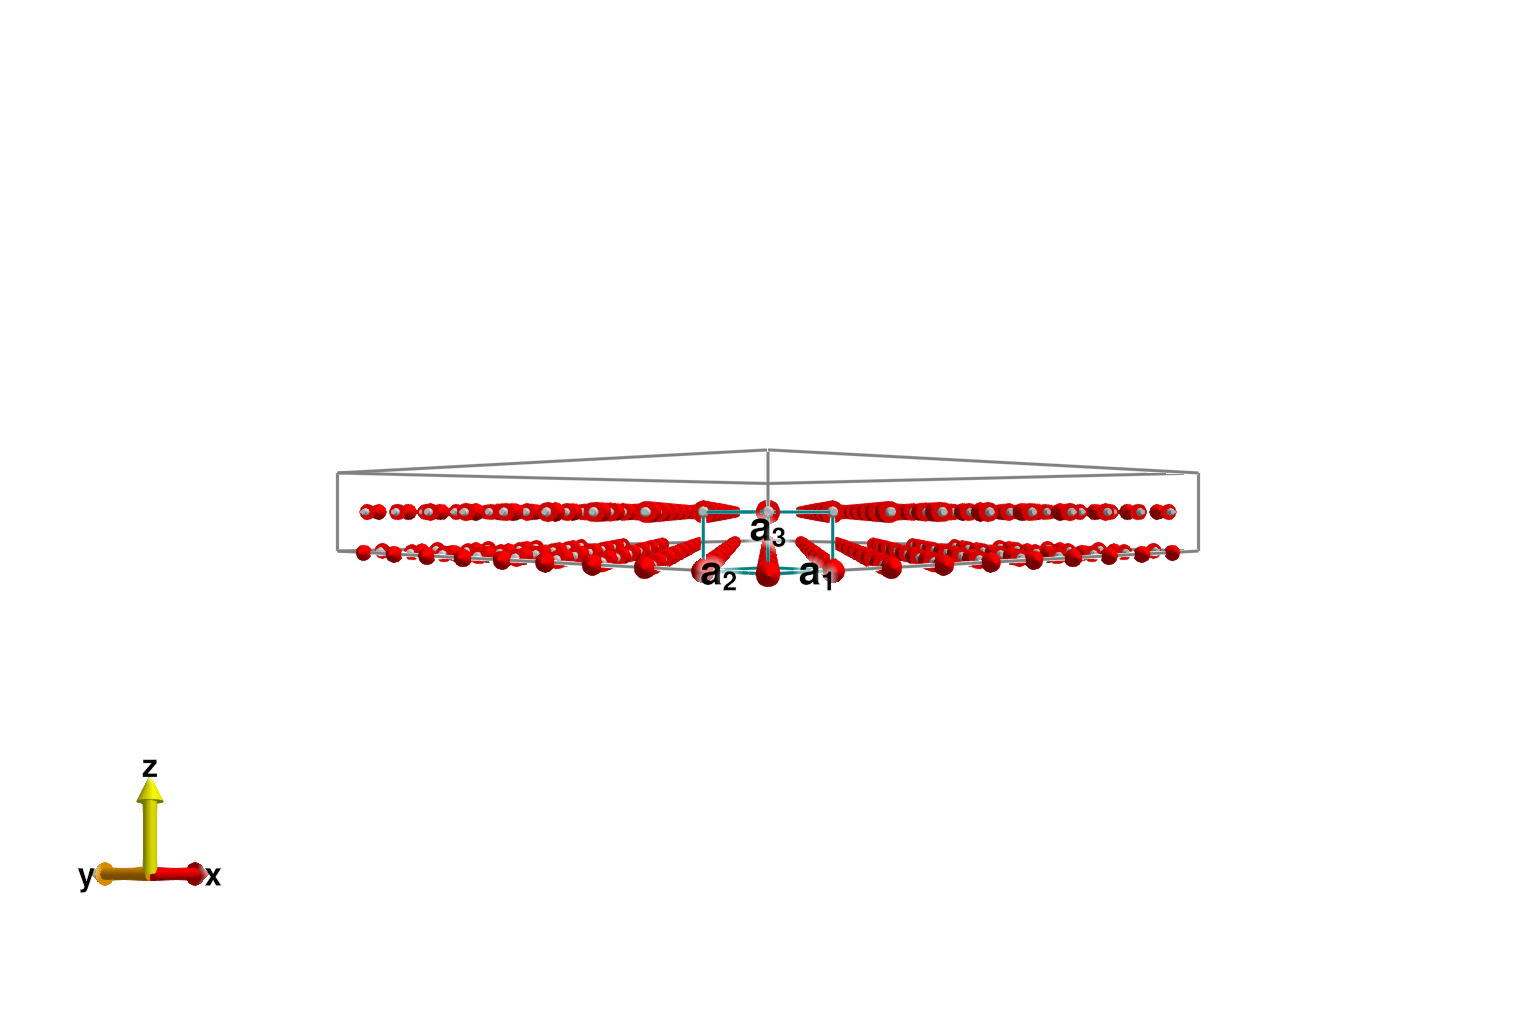

In [23]:
set_external_field!(sys, (0, 0, 0))
minimize_energy!(sys)
plot_spins(sys)

We'll next extend the length of the local dipoles by applying a
sublattice-dependent local field.

In [24]:
xy = [√2/2, √2/2, 0]  # Unit vector in the (1, 1, 0) direction
for site in eachsite(sys)
    sublattice = (-1)^(site.I[4]) * (-1)^(site.I[3])
    M_xy = set_external_field_at!(sys, 50*sublattice * xy, site)
end

minimize_energy!(sys)

8

We'll remove the magnetic fields and then run a classical trajectory using the
generalized Landau-Lifshitz equations. This will allow us to see the
longitudinal oscillations.

In [25]:
set_external_field!(sys, (0, 0, 0))
integrator = ImplicitMidpoint(dt)
suggest_timestep(sys, integrator; tol=1e-2)
integrator.dt = 0.01

fig = plot_spins(sys; colorfn=i->norm(sys.dipoles[i][3]))

for _ in 1:500
    for _ in 1:5
        step!(sys, integrator)
    end
    notify(fig)
    sleep(1/60)
end

Consider dt ≈ 0.03931 for this spin configuration at tol = 0.01. Current value is dt = 0.04.


This is an important observation: when we go to the SU(_N_) formalism,
longitudinal oscillations become something possible at a classical level as a
consequence of the local physics rather than true many-body quantum effects.
When we quantize the result below using the SU(_N_) approach (a kind of
multiflavor boson theory), we _will_ be able to capture this longitudinal
oscillation at the linear level, that is, without loop expansions.

We now move onto our spin wave calculation by making a new BFSO system
representing a single magnetic unit cell. We'll do this both using SU(_N_)
mode, as well as dipole mode. We'll start with a small system to make
optimization easy.

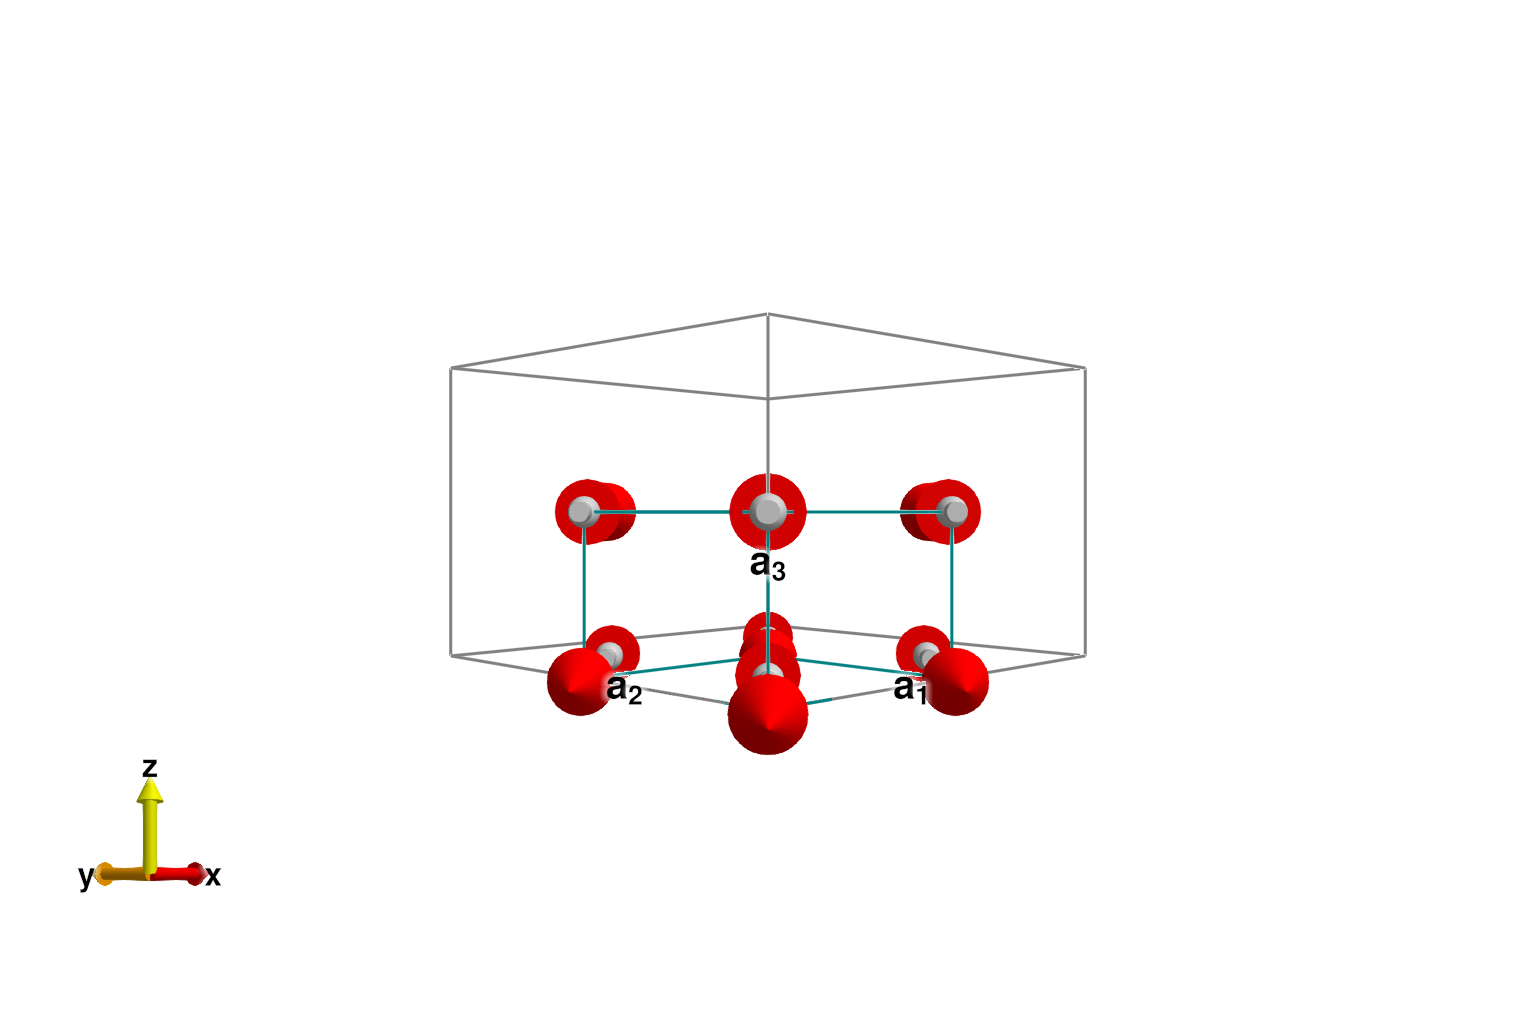

In [26]:
sys_sun = BFSO((2, 2, 2); mode=:SUN)
sys_dip = BFSO((2, 2, 2); mode=:dipole)

randomize_spins!(sys_sun)
minimize_energy!(sys_sun)
plot_spins(sys_sun)

We'll set the ground state for the `:dipole` system to the corresponding
degenerate ground state so our paths through reciprocal space correspond as
well.

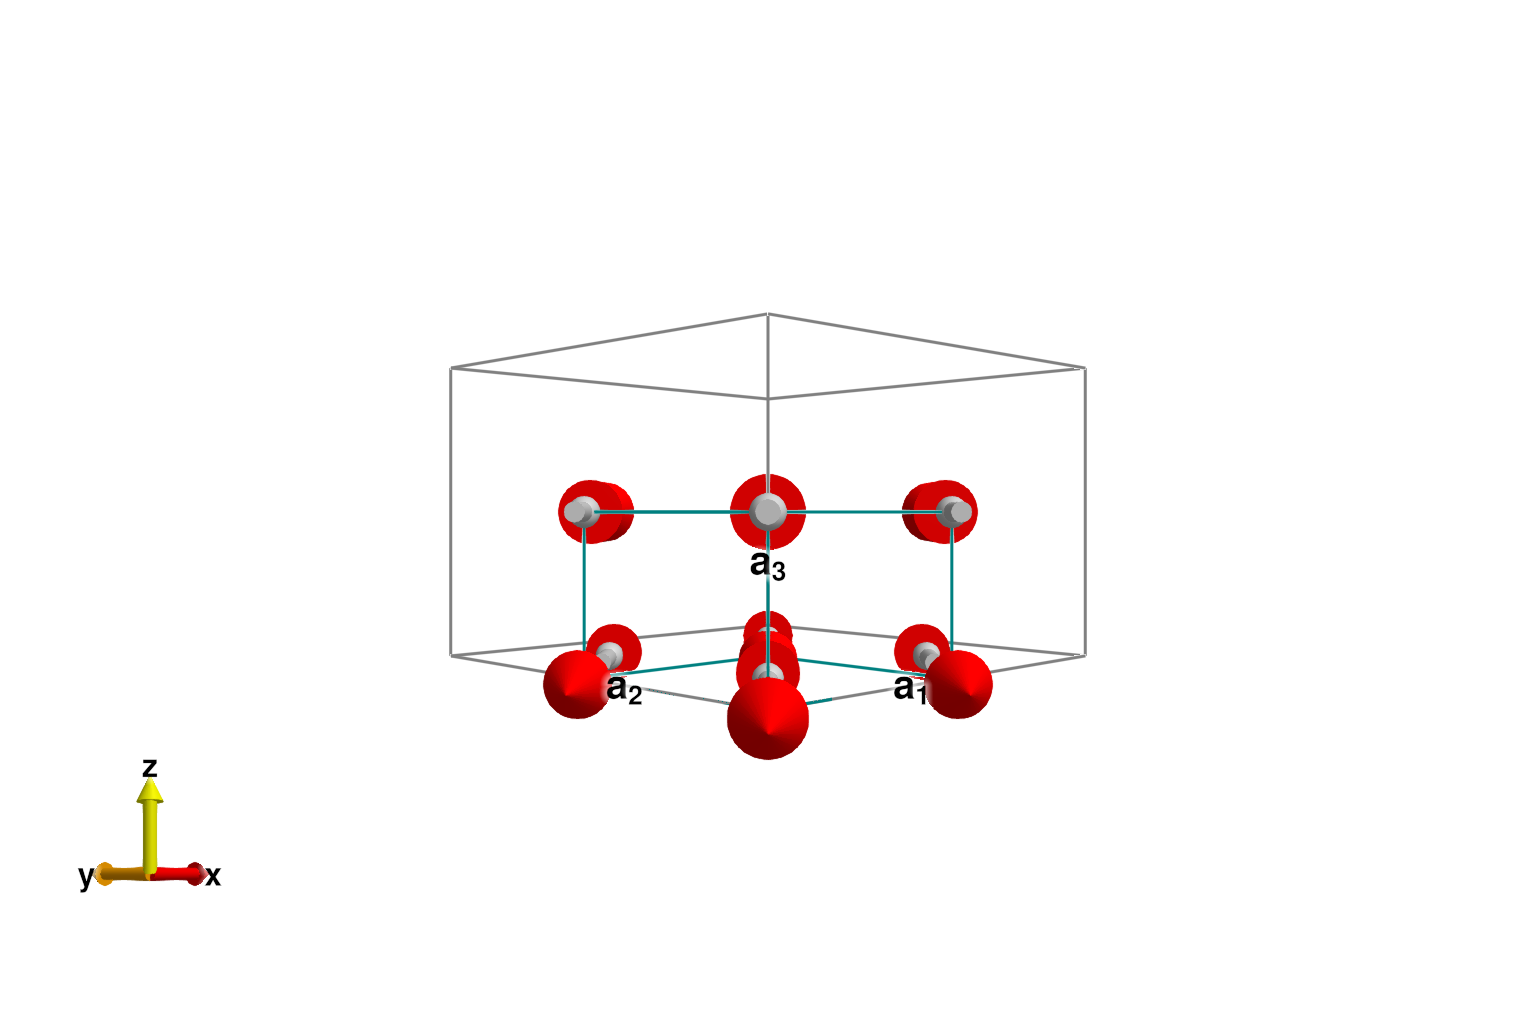

In [27]:
for site in eachsite(sys_dip)
    set_dipole!(sys_dip, sys_sun.dipoles[site], site)
end
minimize_energy!(sys_dip)
plot_spins(sys_dip)

Now we'll reduce to a single magnetic unit cell.

In [28]:
print_wrapped_intensities(sys_dip)
suggest_magnetic_supercell([[0, 0, 1/2]])
sys_dip = reshape_supercell(sys_dip, [1 0 0; 0 1 0; 0 0 2])
sys_sun = reshape_supercell(sys_sun, [1 0 0; 0 1 0; 0 0 2])

Dominant wavevectors for spin sublattices:

    [0, 0, 1/2]           100.00% weight
Possible magnetic supercell in multiples of lattice vectors:

    [1 0 0; 0 1 0; 0 0 2]

for the rationalized wavevectors:

    [[0, 0, 1/2]]


System [SU(5)]
Reshaped lattice (1×1×2)×2
Reshaped cell [1 0 0
               0 1 0
               0 0 1]
Energy per site 2.377


Finally, we'll create `SpinWaveTheory`s for both systems.

In [29]:
swt_dip = SpinWaveTheory(sys_dip)
swt_sun = SpinWaveTheory(sys_sun)

SpinWaveTheory
Atoms in magnetic supercell: 4
╔ ⬤ ⬤ ⬤ Sx
║ ⋅ ⬤ ⬤ Sy
╚ ⋅ ⋅ ⬤ Sz


We're now in a position to extract dispersions and intensities. First
define a path in reciprocal space that we wish to examine.

In [30]:
points_rlu = [[0, 0, 1/2], [1, 0, 1/2], [2, 0, 1/2], [3, 0, 1/2]]
density = 300
path, xticks = reciprocal_space_path(sys.crystal, points_rlu, density);

# EXERCISE: After completing this section, repeat the same steps using a different path
# through reciprocal space:
# points_rlu_alt = [[0, 0, 1/2], [1/2, 1/2, 1/2],[1, 1, 1/2],[3/2, 3/2, 1/2]]

Next specify how we would like Sunny to calculate the intensities, and then
calculate both the dispersion curves as well as intensities with artificial
broadening.

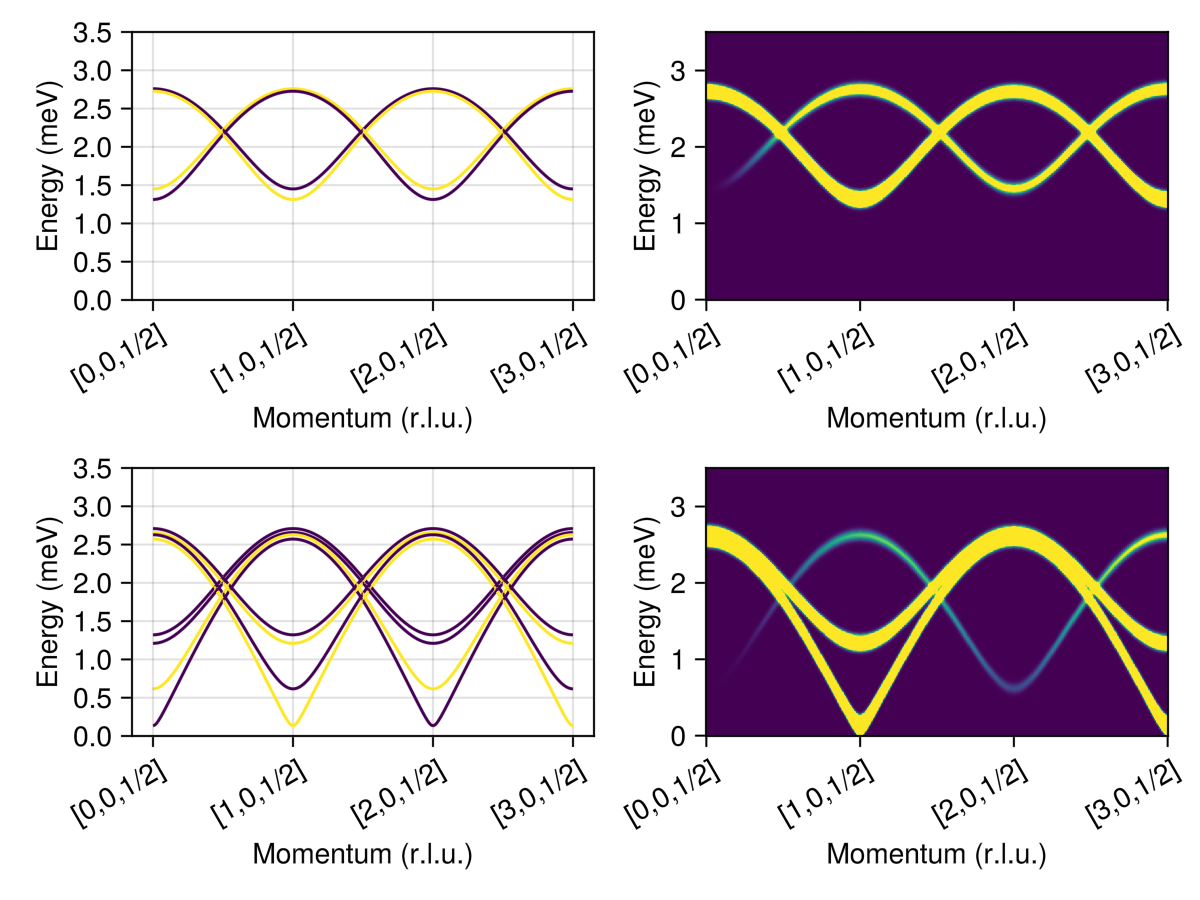

In [31]:
formula_disp_dip = intensity_formula(swt_dip, :perp; kernel=delta_function_kernel)
formula_disp_sun = intensity_formula(swt_sun, :perp; kernel=delta_function_kernel)

disp_dip, is_disp_dip = intensities_bands(swt_dip, path, formula_disp_dip)
disp_sun, is_disp_sun = intensities_bands(swt_sun, path, formula_disp_sun)

fwhm = 0.1
formula_dip = intensity_formula(swt_dip, :perp; kernel=Sunny.gaussian(; fwhm))
formula_sun = intensity_formula(swt_sun, :perp; kernel=Sunny.gaussian(; fwhm))

energies = range(0, 3.5, 400)
is_dip = intensities_broadened(swt_dip, path, energies, formula_dip)
is_sun = intensities_broadened(swt_sun, path, energies, formula_sun)

fig = Figure()
ax1 = Axis(fig[1,1]; xlabel="Momentum (r.l.u.)", ylabel="Energy (meV)", xticks=xticks, xticklabelrotation=π/6)
ax2 = Axis(fig[2,1]; xlabel="Momentum (r.l.u.)", ylabel="Energy (meV)", xticks=xticks, xticklabelrotation=π/6)
ax3 = Axis(fig[1,2]; xlabel="Momentum (r.l.u.)", ylabel="Energy (meV)", xticks=xticks, xticklabelrotation=π/6)
ax4 = Axis(fig[2,2]; xlabel="Momentum (r.l.u.)", ylabel="Energy (meV)", xticks=xticks, xticklabelrotation=π/6)
ylims!(ax1, 0, 3.5)
ylims!(ax2, 0, 3.5)
for i in axes(disp_dip, 2)
    lines!(ax1, 1:length(disp_dip[:,i]), disp_dip[:,i]; color=is_disp_dip[:,i], colorrange=(0,1e-5))
end
for i in axes(disp_sun, 2)
    lines!(ax2, 1:length(disp_sun[:,i]), disp_sun[:,i]; color=is_disp_sun[:,i], colorrange=(0,1e-5))
end
heatmap!(ax3, 1:size(is_dip, 1), energies, is_dip; colorrange=(0.0, 10))
heatmap!(ax4, 1:size(is_sun, 1), energies, is_sun; colorrange=(0.0, 10))
fig

# 6. S(q,ω) with classical dynamics

We noted above that the longitudinal mode should actually decay, an effect
that can only be captured when going beyond linear SWT by adding 1-loop
corrections. While this is a planned future for Sunny, we note for now that
some of these effects can be capture in finite-temperature simulations using
the classical dynamics. Intuitively, this is possible because the classical
dynamics is never linearized, unlike LSWT, so "magnon-magnon" interactions are
included up to arbitrary order.

In this next section, we'll calculate 𝒮(q,ω) using the generalized classical
dynamics, examining the exact same path through reciprocal space, only this
time we'll perform the simulation at T > 0. To start with, we'll make another
BFSO system. This time, however, we'll need a large unit cell, rather than a
single unit cell.

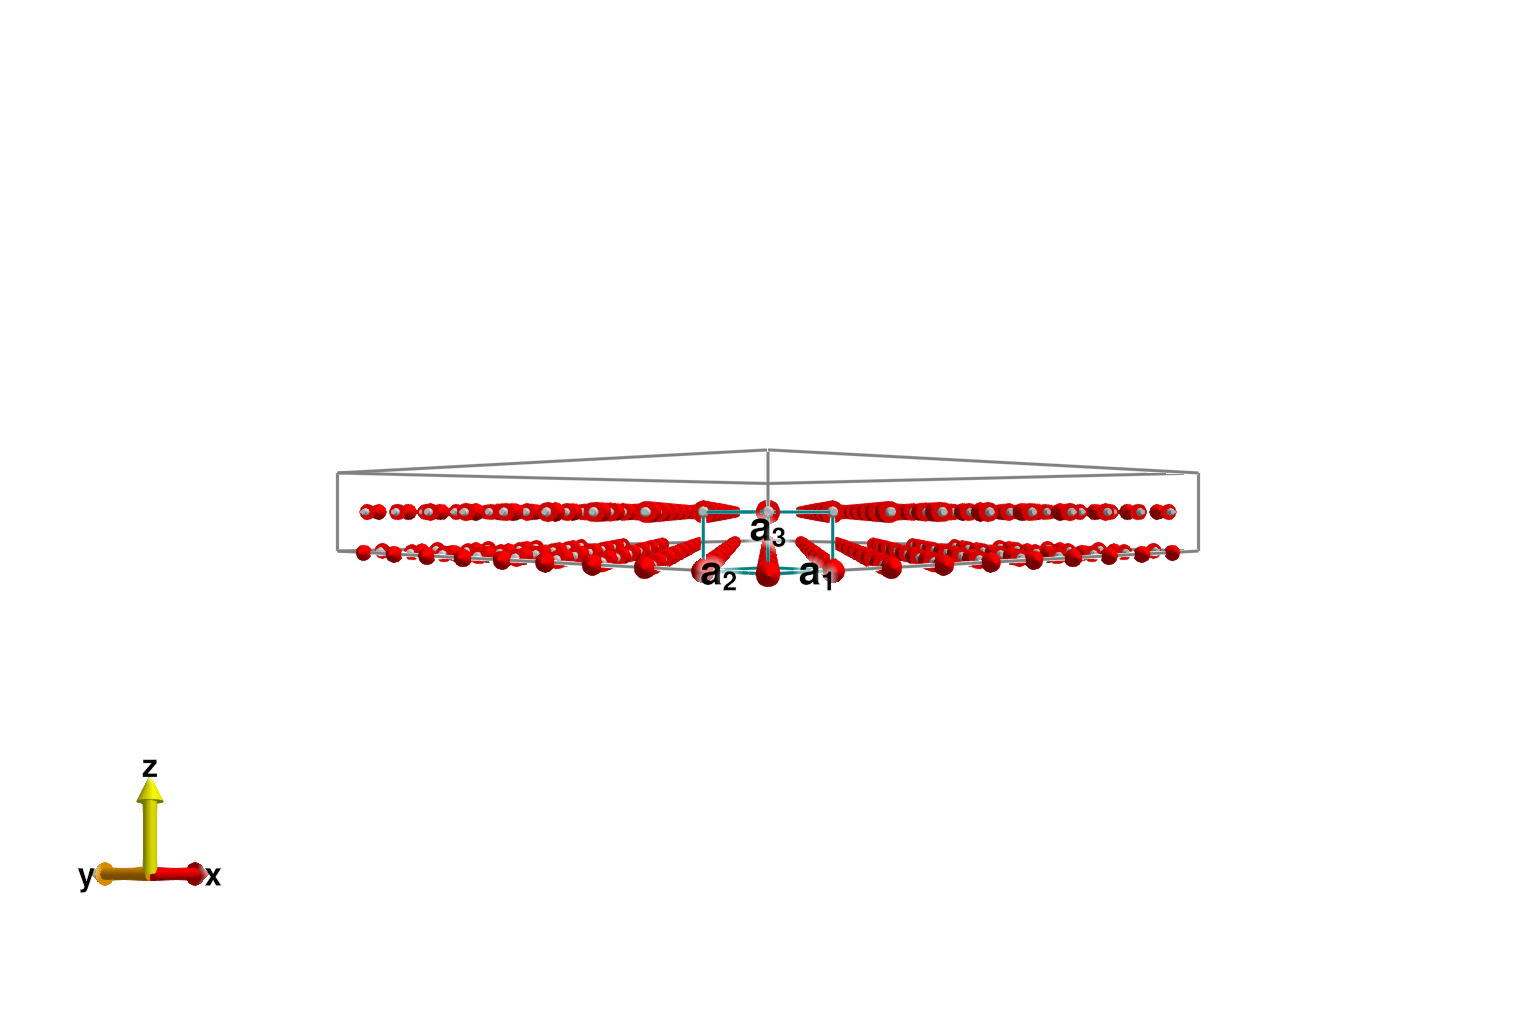

In [32]:
sys = repeat_periodically(sys_sun, (10, 10, 1))
minimize_energy!(sys)
plot_spins(sys)

Next we'll make a `Langevin` integrator to thermalize and decorrelate the system.

In [33]:
kT = 0.1 * meV_per_K
integrator = Langevin(; kT, damping=0.1)
suggest_timestep(sys, integrator; tol=1e-2)
integrator.dt = dt = 0.04

Consider dt ≈ 0.04579 for this spin configuration at tol = 0.01.


0.04

Now we'll create a `SampledCorrelations` objects to collect information about
trajectory correlations.

In [34]:
nω = 200
ωmax = 3.5
dt = 0.04
sc = dynamical_correlations(sys; nω, ωmax, dt)

nsamples = 10
for _ in 1:nsamples
    # Thermalize the system
    for _ in 1:500
        step!(sys, integrator)
    end

    # Add a trajectory
    @time add_sample!(sc, sys)
end

  2.473904 seconds (1.68 M allocations: 117.302 MiB, 0.48% gc time)
  2.315271 seconds (1.68 M allocations: 117.267 MiB)
  2.324523 seconds (1.68 M allocations: 117.267 MiB, 0.55% gc time)
  2.315353 seconds (1.68 M allocations: 117.267 MiB)
  2.331203 seconds (1.68 M allocations: 117.267 MiB, 0.54% gc time)
  2.315146 seconds (1.68 M allocations: 117.267 MiB)
  2.314172 seconds (1.68 M allocations: 117.267 MiB)
  2.326210 seconds (1.68 M allocations: 117.267 MiB, 0.55% gc time)
  2.313345 seconds (1.68 M allocations: 117.267 MiB)
  2.325127 seconds (1.68 M allocations: 117.267 MiB, 0.55% gc time)


The procedure for extracting intensities is broadly similar to the LSWT case.
First we have to specify a "formula" telling Sunny how the intensities should
be calculated.

In [35]:
formula = intensity_formula(sc, :perp; kT)

Classical Scattering Intensity Formula
At discrete scattering modes S = S[ix_q,ix_ω], use:

  Intensity[ix_q,ix_ω] =   Intensity[ix_q,ix_ω] = ∑_ij (I - Q⊗Q){i,j} S{i,j}
                         
                         (i,j = Sx,Sy,Sz)
No form factors specified
Temperature corrected (kT = 0.008617333262145177) ✓


We can then reuse the same path we specified above and compare to the LSWT
result.

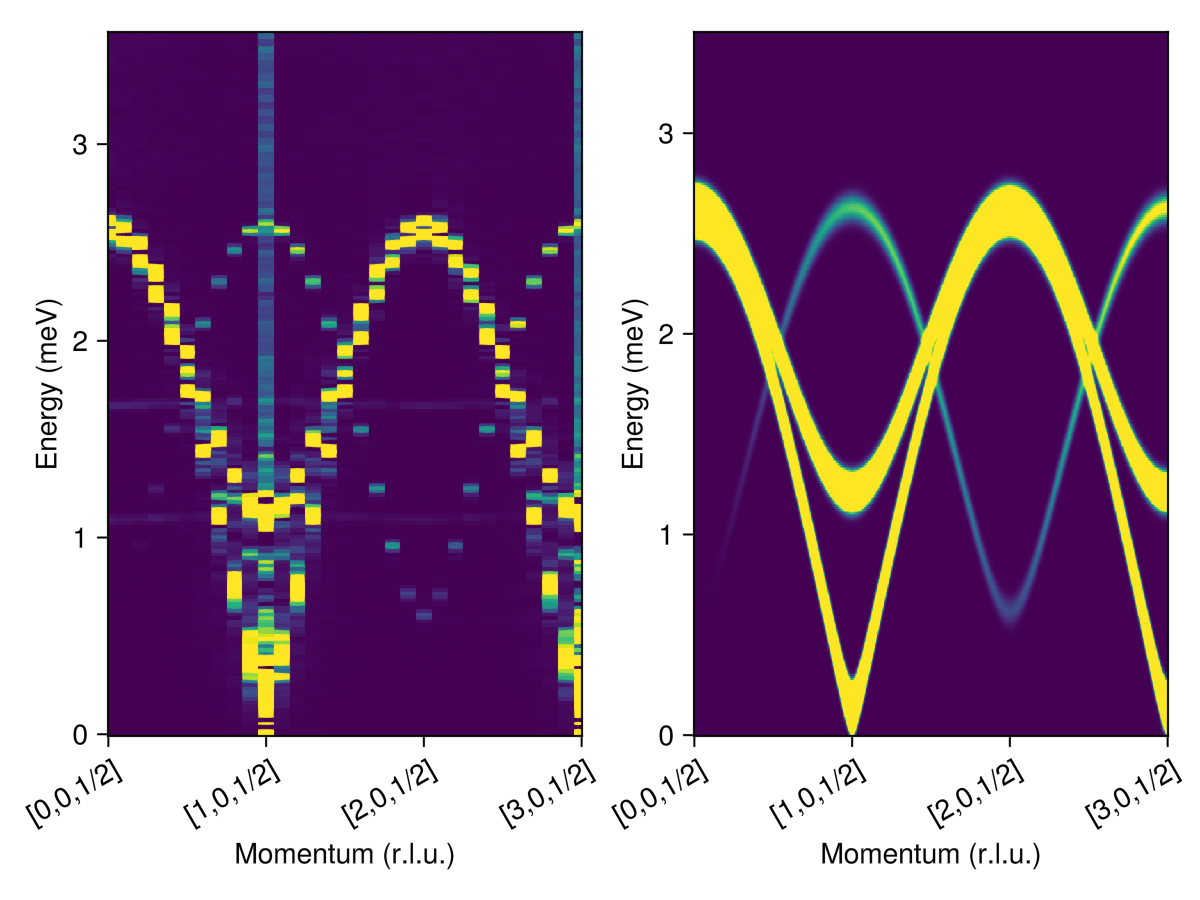

In [36]:
is = intensities_interpolated(sc, path, formula)

fig = Figure()
ax1 = Axis(fig[1,1]; xlabel="Momentum (r.l.u.)", ylabel="Energy (meV)", xticks=xticks, xticklabelrotation=π/6)
ax2 = Axis(fig[1,2]; xlabel="Momentum (r.l.u.)", ylabel="Energy (meV)", xticks=xticks, xticklabelrotation=π/6)
heatmap!(ax1, 1:size(is, 1), available_energies(sc), is; colorrange=(0.0, maximum(is)/3000))
heatmap!(ax2, 1:size(is_sun, 1), energies, is_sun; colorrange=(0.0, 10))
fig

Now let's repeat the procedure above at several different temperatures.

  2.484564 seconds (1.68 M allocations: 117.267 MiB, 0.54% gc time)
  2.460447 seconds (1.68 M allocations: 117.267 MiB)
  2.464735 seconds (1.68 M allocations: 117.267 MiB)
  2.477767 seconds (1.68 M allocations: 117.267 MiB, 0.64% gc time)
  2.465579 seconds (1.68 M allocations: 117.267 MiB)
  2.478657 seconds (1.68 M allocations: 117.267 MiB, 0.55% gc time)
  2.462496 seconds (1.68 M allocations: 117.267 MiB)
  2.465226 seconds (1.68 M allocations: 117.267 MiB)
  2.477225 seconds (1.68 M allocations: 117.267 MiB, 0.59% gc time)
  2.463440 seconds (1.68 M allocations: 117.267 MiB)
  2.475002 seconds (1.68 M allocations: 117.267 MiB, 0.49% gc time)
  2.470679 seconds (1.68 M allocations: 117.267 MiB)
  2.484718 seconds (1.68 M allocations: 117.267 MiB, 0.56% gc time)
  2.502244 seconds (1.68 M allocations: 117.267 MiB)
  2.560583 seconds (1.68 M allocations: 117.267 MiB)
  2.536431 seconds (1.68 M allocations: 117.267 MiB, 0.70% gc time)
  2.541904 seconds (1.68 M allocations: 117.267

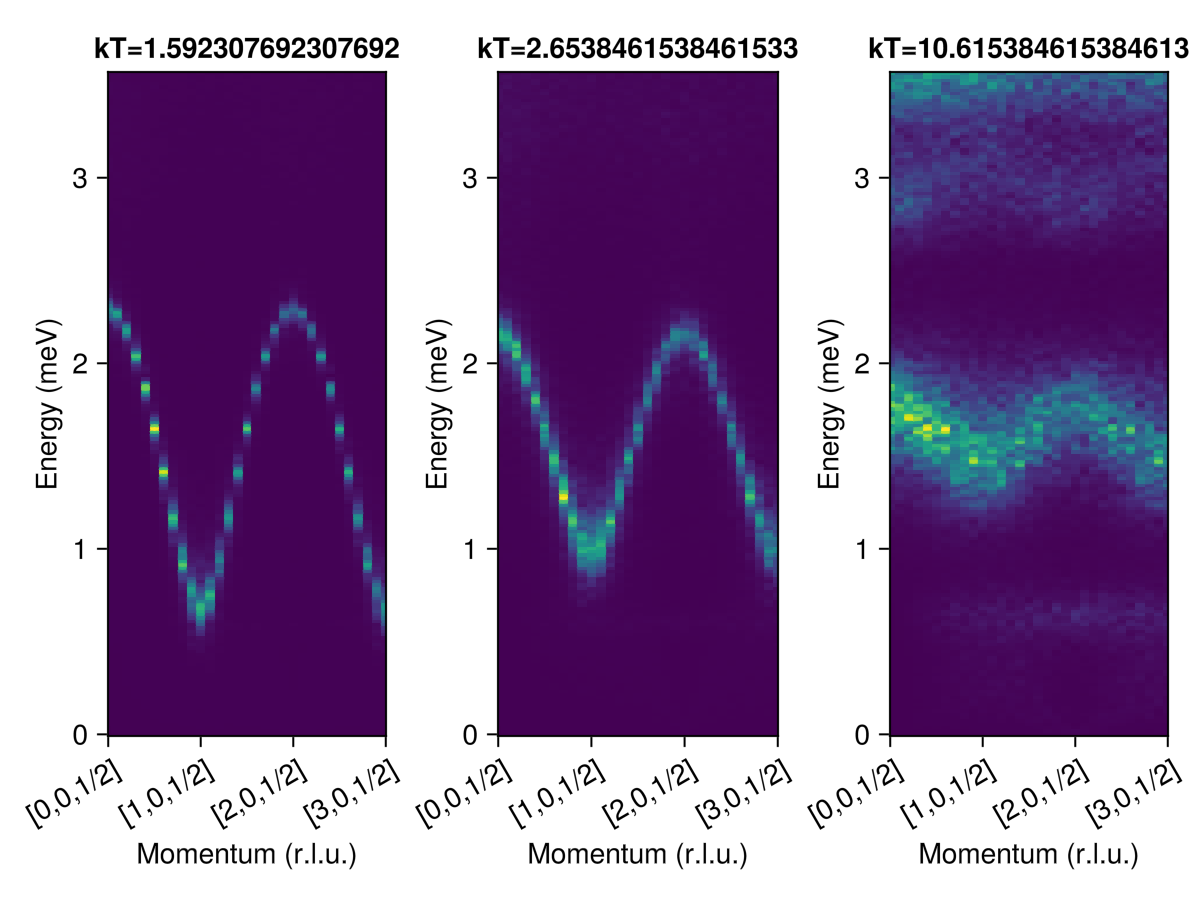

In [37]:
kTs_K = [6, 10, 40] .* (1.38/5.2)
kTs = kTs_K * meV_per_K
scs = []
for kT in kTs
    sc = dynamical_correlations(sys; nω, ωmax, dt)
    integrator.kT = kT

    # Collect correlations from trajectories
    for _ in 1:nsamples
        # Thermalize/decorrelate the system
        for _ in 1:500
            step!(sys, integrator)
        end

        # Add a trajectory
        @time add_sample!(sc, sys)
    end

    push!(scs, sc)
end

fig = Figure()
for (n, sc) in enumerate(scs)
    is = intensities_interpolated(sc, path, formula)
    ax = Axis(fig[1,n]; xlabel="Momentum (r.l.u.)", ylabel="Energy (meV)", xticks=xticks, xticklabelrotation=π/6, title="kT=$(kTs_K[n])")
    heatmap!(ax, 1:size(is, 1), available_energies(sc), is)
end
fig

Notice that the longitudinal mode, which decays when 1-loop corrections are
applied, is extremely delicate in the classical simulations, dropping in energy
and intensity quite rapidly as the temperature is increased.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*